**Dataset Name** - Human Activity Recognition Using Smartphones (UCI)

**Date** - 12/9/2012

**Description** - This dataset "built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors." It contians several files contianing measurements for gyroscopic information and acceleartion.

**License** - "This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given."

**Motivatio**n - We are primarily interested in the intertial signals daa. Our goal is to use it to predict the type of movement conducted by the subjects.

**Target** - A number 1-6 corresponding to a different type of movement.

**Signals** - Body Acceleration, Total Acceleration, Body Gyroscope, each of which are measured in 3 dimensions. The window length is 2.56 seconds with 128 readings per window.

**Limitations/Risks** - The study was conducted on a relatively small sample, only 30 participants, and the sample was conducted only on Samsung Galaxy S II smart phones, so the data might not generalize to other smart phones well.

In [ ]:
# load the dataset
import pandas as pd
import numpy as np
import os


signals = []

for file in os.listdir('intertial_signals'):
    data = pd.read_csv(os.path.join('intertial_signals', file), sep=r"\s+", header=None)
    signals.append(data)

data = np.stack(signals, axis=-1)
y = pd.read_csv('y_train.txt', sep=r"\s+", header=None).squeeze()
subjects = pd.read_csv('subject_train.txt', sep=r"\s+", header=None).squeeze()


In [ ]:
print(data.shape)
print(y.shape)
print(subjects.shape)

# confirm no presence of NaN / inf
print(np.isnan(data).any())
print(np.isinf(data).any())
print(np.isnan(y).any())
print(np.isinf(y).any())
print(np.isnan(subjects).any())
print(np.isinf(subjects).any())

(7352, 128, 9)
(7352,)
(7352,)
False
False
False
False
False
False


In [ ]:
# subject disjoint split

unique = np.unique(subjects)
np.random.seed(42)

train_subjects = np.random.choice(unique, size=int(0.8 * len(unique)), replace=False)
val_subjects = np.setdiff1d(unique, train_subjects)

train_mask = np.isin(subjects, train_subjects)
val_mask = np.isin(subjects, val_subjects)

X_train = data[train_mask]
y_train = y[train_mask]

X_val = data[val_mask]
y_val = y[val_mask]

overlap = set(train_subjects).intersection(set(val_subjects))
print("Overlap count:", len(overlap))

Subject overlap: set()
Overlap count: 0


In [ ]:
# Trivial predictor
from collections import Counter

counter = Counter(y)
print(counter)

# predict 6 for all samples
y_pred = np.full_like(y_val, fill_value=6)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       291
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       239
           4       0.00      0.00      0.00       299
           5       0.00      0.00      0.00       318
           6       0.19      1.00      0.31       320

    accuracy                           0.19      1723
   macro avg       0.03      0.17      0.05      1723
weighted avg       0.03      0.19      0.06      1723



C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [ ]:
# Baseline model using MLP

from sklearn.neural_network import MLPClassifier
# Reshape data for MLP
n_samples, n_timesteps, n_features = X_train.shape
X_train_r = X_train.reshape(n_samples, n_timesteps * n_features)

n_samples_val, n_timesteps_val, n_features_val = X_val.shape
X_val_r = X_val.reshape(n_samples_val, n_timesteps_val * n_features_val)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10, random_state=42)

mlp.fit(X_train_r, y_train)
y_pred_mlp = mlp.predict(X_val_r)

print(classification_report(y_val, y_pred_mlp))

              precision    recall  f1-score   support

           1       0.94      0.77      0.85       291
           2       0.69      0.99      0.82       256
           3       0.98      0.73      0.84       239
           4       0.88      0.89      0.88       299
           5       0.89      0.88      0.89       318
           6       1.00      1.00      1.00       320

    accuracy                           0.88      1723
   macro avg       0.90      0.88      0.88      1723
weighted avg       0.90      0.88      0.88      1723



C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


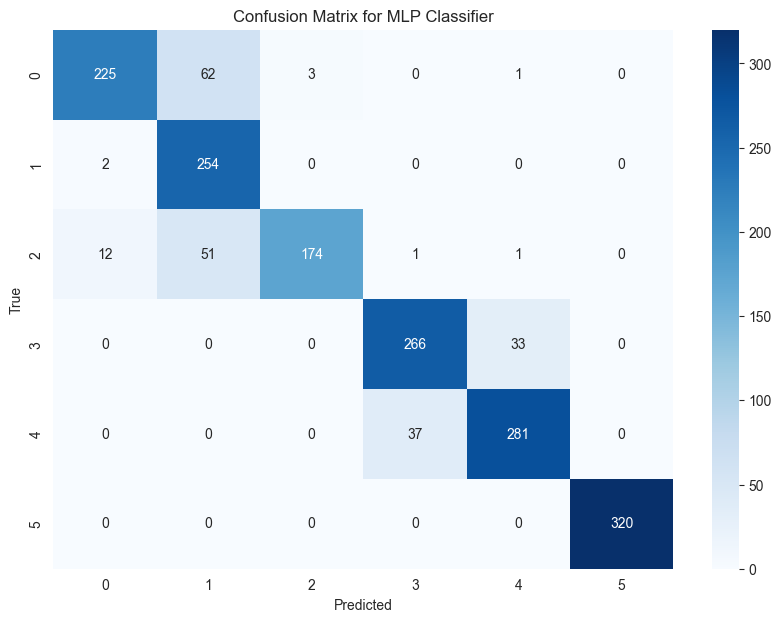

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_pred_mlp)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()